# Bonus2: Build a Supervised Autoencoder.

### Name: Tara Lozy



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus2/Bonus2.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [86]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)              

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [65]:
# tuning learning rate 
from keras import optimizers

learning_rate = 1E-1 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))
history_1 = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 0s 5ms/step - loss: 4588976128.0000 - val_loss: 0.1067
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.1054 - val_loss: 0.1074
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.1050 - val_loss: 0.1051
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 0.1032 - val_loss: 0.1039
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0771
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0741 - val_loss: 0.0770
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0741 - val_loss: 0.0780
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0743 - val_loss: 0.0784
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0743 - val_loss: 0.0769
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0744 - val_loss: 0.0778


Epoch 83/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0762 - val_loss: 0.0791
Epoch 84/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0762 - val_loss: 0.0782
Epoch 85/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0762 - val_loss: 0.0791
Epoch 86/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0762 - val_loss: 0.0785
Epoch 87/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0762 - val_loss: 0.0791
Epoch 88/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0762 - val_loss: 0.0800
Epoch 89/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0762 - val_loss: 0.0827
Epoch 90/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0763 - val_loss: 0.0780
Epoch 91/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0763 - val_loss: 0.0799
Epoch 92/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0765 - val_loss: 0.0793


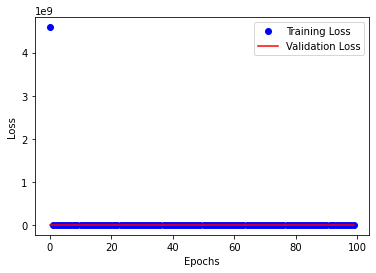

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
# tuning learning rate 
from keras import optimizers

learning_rate = 1E-2 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))
history_2 = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 0s 5ms/step - loss: 0.5408 - val_loss: 0.0851
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0811 - val_loss: 0.0702
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0661 - val_loss: 0.0686
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0603 - val_loss: 0.0584
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0564
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0528
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0521
Epoch 8/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0530
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0502
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0505
Epoch 11/

79/79 [==============================] - 0s 4ms/step - loss: 0.0439 - val_loss: 0.0462
Epoch 84/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0436 - val_loss: 0.0465
Epoch 85/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0461
Epoch 86/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0489
Epoch 87/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0440 - val_loss: 0.0451
Epoch 88/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0439 - val_loss: 0.0468
Epoch 89/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0441 - val_loss: 0.0456
Epoch 90/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0522
Epoch 91/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0441 - val_loss: 0.0460
Epoch 92/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0439 - val_loss: 0.0477
Epoch 93/100


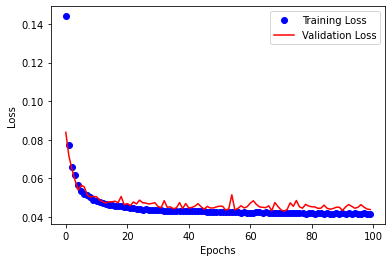

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
# this is the final chosen parameters 
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))
history_3 = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0782 - val_loss: 0.0729
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0721 - val_loss: 0.0716
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0700 - val_loss: 0.0689
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0684 - val_loss: 0.0683
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0671 - val_loss: 0.0670
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0650 - val_loss: 0.0641
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0634 - val_loss: 0.0634
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0619 - val_loss: 0.0631
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0611 - val_loss: 0.0617
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 0.0608
Epoch 11/

79/79 [==============================] - 0s 5ms/step - loss: 0.0433 - val_loss: 0.0467
Epoch 84/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0435 - val_loss: 0.0456
Epoch 85/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0461
Epoch 86/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0431 - val_loss: 0.0455
Epoch 87/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0453
Epoch 88/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0430 - val_loss: 0.0454
Epoch 89/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0430 - val_loss: 0.0453
Epoch 90/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0429 - val_loss: 0.0452
Epoch 91/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0430 - val_loss: 0.0455
Epoch 92/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0454
Epoch 93/100


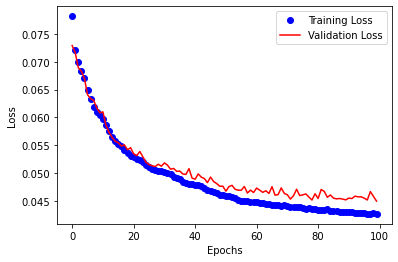

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
# tuning learning rate 
from keras import optimizers

learning_rate = 1E-4 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))
history_4 = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0956 - val_loss: 0.0838
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0823 - val_loss: 0.0816
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 0.0804
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0796
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0796 - val_loss: 0.0796
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0796 - val_loss: 0.0796
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0796 - val_loss: 0.0795
Epoch 8/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0795
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0795
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0794
Epoch 11/

79/79 [==============================] - 0s 5ms/step - loss: 0.0680 - val_loss: 0.0680
Epoch 84/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0678 - val_loss: 0.0679
Epoch 85/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0678 - val_loss: 0.0679
Epoch 86/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0677 - val_loss: 0.0678
Epoch 87/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0677 - val_loss: 0.0678
Epoch 88/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0676 - val_loss: 0.0678
Epoch 89/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0676 - val_loss: 0.0677
Epoch 90/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0675 - val_loss: 0.0677
Epoch 91/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0675 - val_loss: 0.0677
Epoch 92/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 93/100


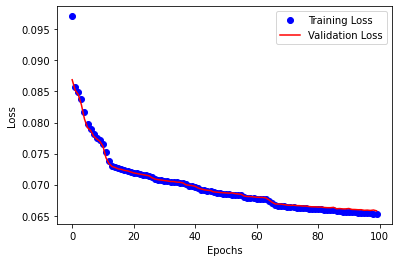

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
# tuning learning rate 
from keras import optimizers

learning_rate = 1E-5 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))
history_5 = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 0s 6ms/step - loss: 0.1092 - val_loss: 0.1082
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.1071 - val_loss: 0.1059
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 0.1046 - val_loss: 0.1032
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.1018 - val_loss: 0.1002
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0988 - val_loss: 0.0973
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0961 - val_loss: 0.0948
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0938 - val_loss: 0.0929
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0921 - val_loss: 0.0913
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0906 - val_loss: 0.0900
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0895 - val_loss: 0.0890
Epoch 11/

79/79 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0774
Epoch 84/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0774
Epoch 85/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0774
Epoch 86/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0773
Epoch 87/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0773
Epoch 88/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0773
Epoch 89/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0773
Epoch 90/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0773
Epoch 91/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0772
Epoch 92/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 0.0770
Epoch 93/100


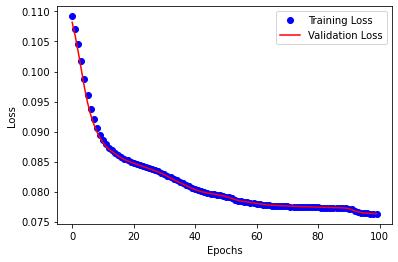

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

A learning rate of 1E-5 appears to have the best fit between the training dataset and the validation dataset. However, the learning is slow. Therefore, I've selected a learning rate of 1E-2. The loss after 100 epochs is similar to 1E-3 but the fit is slightly better

### 2.3. Visualize the reconstructed test images

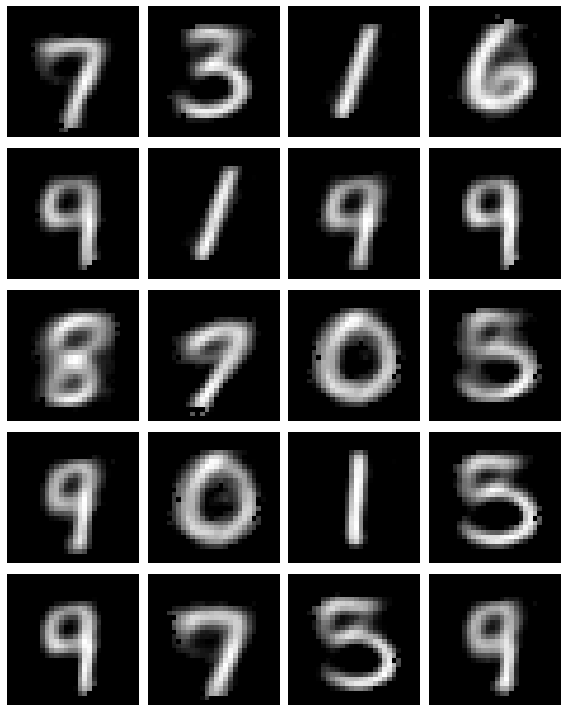

In [88]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [89]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 0s 686us/step - loss: 0.0490
loss = 0.0489843413233757


### 2.5. Visualize the low-dimensional features

In [90]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [91]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


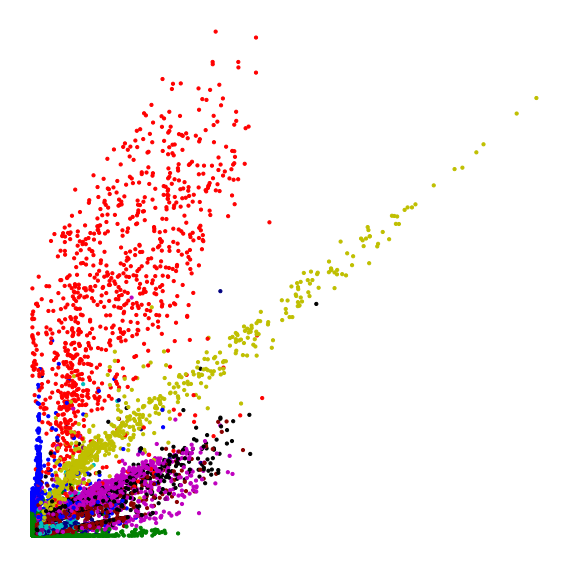

In [92]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [93]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [94]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [95]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 0s 1ms/step - loss: 1.9331 - acc: 0.2321 - val_loss: 1.7612 - val_acc: 0.3418
Epoch 2/30
313/313 [==============================] - 0s 909us/step - loss: 1.7028 - acc: 0.3854 - val_loss: 1.6310 - val_acc: 0.4335
Epoch 3/30
313/313 [==============================] - 0s 956us/step - loss: 1.5944 - acc: 0.4898 - val_loss: 1.5427 - val_acc: 0.5142
Epoch 4/30
313/313 [==============================] - 0s 834us/step - loss: 1.5107 - acc: 0.5502 - val_loss: 1.4617 - val_acc: 0.5620
Epoch 5/30
313/313 [==============================] - 0s 847us/step - loss: 1.4351 - acc: 0.5774 - val_loss: 1.3948 - val_acc: 0.5790
Epoch 6/30
313/313 [==============================] - 0s 850us/step - loss: 1.3692 - acc: 0.5835 - val_loss: 1.3366 - val_acc: 0.5790
Epoch 7/30
313/313 [==============================] - 0s 848us/step - loss: 1.3139 - acc: 0.5935 - val_loss: 1.2911 - val_acc: 0.5891
Epoch 8/30
313/313 [==============================] - 0s 844us/s

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [156]:
# build the supervised autoencoder network
from keras.layers import Dense, Input, Dropout
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
regularization1 = Dropout(0.5, name='regularization1')(encode1)
encode2 = Dense(32,  activation='relu', name='encode2')(regularization1)
encode3 = Dense(8,   activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(8,   activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32,  activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
regularization2 = Dropout(0.5, name='regularization2')(decode3)
decode4 = Dense(784, activation='relu', name='decode4')(regularization2)

# build a classifier upon the bottleneck layer
classifier1 = Dense(100, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(100, activation='relu', name='classifier2')(classifier1)
regularization = Dropout(0.5, name='regularization')(classifier2)
classifier3 = Dense(10,  activation='softmax', name='classifier3')(regularization)


In [157]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "functional_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 128)          100480      input_img[0][0]                  
__________________________________________________________________________________________________
regularization1 (Dropout)       (None, 128)          0           encode1[0][0]                    
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 32)           4128        regularization1[0][0]            
______________________________________________________________________________________

In [37]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [158]:
#this is the model I used for implementation 
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 1s 4ms/step - loss: 0.9468 - decode4_loss: 0.0672 - classifier3_loss: 1.7592 - val_loss: 0.7580 - val_decode4_loss: 0.0622 - val_classifier3_loss: 1.3917
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.7417 - decode4_loss: 0.0628 - classifier3_loss: 1.3577 - val_loss: 0.6048 - val_decode4_loss: 0.0612 - val_classifier3_loss: 1.0870
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.6024 - decode4_loss: 0.0615 - classifier3_loss: 1.0817 - val_loss: 0.4922 - val_decode4_loss: 0.0593 - val_classifier3_loss: 0.8658
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5255 - decode4_loss: 0.0604 - classifier3_loss: 0.9303 - val_loss: 0.4313 - val_decode4_loss: 0.0588 - val_classifier3_loss: 0.7450
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4673 - decode4_loss: 0.0599 - classifier3_loss: 0.8148 - val_loss: 0.4048 - val_decode4

313/313 [==============================] - 1s 4ms/step - loss: 0.1918 - decode4_loss: 0.0541 - classifier3_loss: 0.2753 - val_loss: 0.2394 - val_decode4_loss: 0.0530 - val_classifier3_loss: 0.3727
Epoch 41/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1933 - decode4_loss: 0.0541 - classifier3_loss: 0.2784 - val_loss: 0.2247 - val_decode4_loss: 0.0530 - val_classifier3_loss: 0.3434
Epoch 42/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1903 - decode4_loss: 0.0541 - classifier3_loss: 0.2723 - val_loss: 0.2311 - val_decode4_loss: 0.0531 - val_classifier3_loss: 0.3559
Epoch 43/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1845 - decode4_loss: 0.0541 - classifier3_loss: 0.2608 - val_loss: 0.2455 - val_decode4_loss: 0.0528 - val_classifier3_loss: 0.3855
Epoch 44/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1911 - decode4_loss: 0.0542 - classifier3_loss: 0.2739 - val_loss: 0.2508 - val_decode4_loss: 0

313/313 [==============================] - 1s 5ms/step - loss: 0.1861 - decode4_loss: 0.0540 - classifier3_loss: 0.2643 - val_loss: 0.2635 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.4222
Epoch 80/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1793 - decode4_loss: 0.0538 - classifier3_loss: 0.2510 - val_loss: 0.2644 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4240
Epoch 81/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1739 - decode4_loss: 0.0538 - classifier3_loss: 0.2403 - val_loss: 0.2748 - val_decode4_loss: 0.0521 - val_classifier3_loss: 0.4454
Epoch 82/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1714 - decode4_loss: 0.0537 - classifier3_loss: 0.2354 - val_loss: 0.2552 - val_decode4_loss: 0.0523 - val_classifier3_loss: 0.4059
Epoch 83/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1768 - decode4_loss: 0.0538 - classifier3_loss: 0.2461 - val_loss: 0.2533 - val_decode4_loss: 0

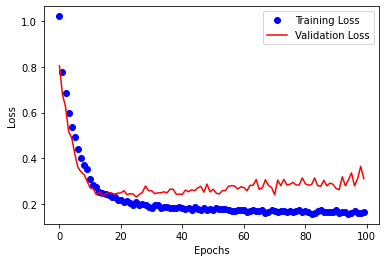

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [148]:
#experimenting with different weights for loss
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1E-1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 1s 4ms/step - loss: 0.8508 - decode4_loss: 0.0663 - classifier3_loss: 1.6884 - val_loss: 0.5827 - val_decode4_loss: 0.0579 - val_classifier3_loss: 1.1537
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.5731 - decode4_loss: 0.0593 - classifier3_loss: 1.1342 - val_loss: 0.4605 - val_decode4_loss: 0.0565 - val_classifier3_loss: 0.9096
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4701 - decode4_loss: 0.0575 - classifier3_loss: 0.9287 - val_loss: 0.4341 - val_decode4_loss: 0.0549 - val_classifier3_loss: 0.8571
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4174 - decode4_loss: 0.0567 - classifier3_loss: 0.8234 - val_loss: 0.3733 - val_decode4_loss: 0.0548 - val_classifier3_loss: 0.7356
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3915 - decode4_loss: 0.0563 - classifier3_loss: 0.7717 - val_loss: 0.3544 - val_decode4

313/313 [==============================] - 1s 4ms/step - loss: 0.1429 - decode4_loss: 0.0534 - classifier3_loss: 0.2751 - val_loss: 0.2305 - val_decode4_loss: 0.0516 - val_classifier3_loss: 0.4506
Epoch 41/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1424 - decode4_loss: 0.0534 - classifier3_loss: 0.2742 - val_loss: 0.2293 - val_decode4_loss: 0.0517 - val_classifier3_loss: 0.4482
Epoch 42/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1465 - decode4_loss: 0.0534 - classifier3_loss: 0.2823 - val_loss: 0.2090 - val_decode4_loss: 0.0523 - val_classifier3_loss: 0.4075
Epoch 43/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1422 - decode4_loss: 0.0534 - classifier3_loss: 0.2737 - val_loss: 0.2193 - val_decode4_loss: 0.0520 - val_classifier3_loss: 0.4282
Epoch 44/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1433 - decode4_loss: 0.0535 - classifier3_loss: 0.2758 - val_loss: 0.2026 - val_decode4_loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.1357 - decode4_loss: 0.0538 - classifier3_loss: 0.2606 - val_loss: 0.2231 - val_decode4_loss: 0.0519 - val_classifier3_loss: 0.4358
Epoch 80/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1377 - decode4_loss: 0.0536 - classifier3_loss: 0.2647 - val_loss: 0.2530 - val_decode4_loss: 0.0522 - val_classifier3_loss: 0.4955
Epoch 81/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1292 - decode4_loss: 0.0538 - classifier3_loss: 0.2475 - val_loss: 0.2333 - val_decode4_loss: 0.0521 - val_classifier3_loss: 0.4562
Epoch 82/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1387 - decode4_loss: 0.0537 - classifier3_loss: 0.2667 - val_loss: 0.2156 - val_decode4_loss: 0.0520 - val_classifier3_loss: 0.4209
Epoch 83/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1421 - decode4_loss: 0.0537 - classifier3_loss: 0.2734 - val_loss: 0.2434 - val_decode4_loss: 0

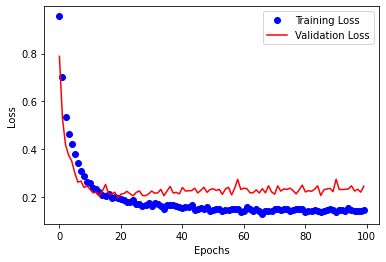

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [140]:
#experimenting with different weights for loss
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1E-1, 0.4], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 1s 4ms/step - loss: 0.6845 - decode4_loss: 0.0676 - classifier3_loss: 1.6944 - val_loss: 0.4936 - val_decode4_loss: 0.0597 - val_classifier3_loss: 1.2190
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4699 - decode4_loss: 0.0602 - classifier3_loss: 1.1597 - val_loss: 0.3826 - val_decode4_loss: 0.0573 - val_classifier3_loss: 0.9421
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4038 - decode4_loss: 0.0590 - classifier3_loss: 0.9948 - val_loss: 0.3437 - val_decode4_loss: 0.0568 - val_classifier3_loss: 0.8452
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3721 - decode4_loss: 0.0585 - classifier3_loss: 0.9156 - val_loss: 0.3214 - val_decode4_loss: 0.0567 - val_classifier3_loss: 0.7892
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3456 - decode4_loss: 0.0582 - classifier3_loss: 0.8494 - val_loss: 0.3104 - val_decode4

313/313 [==============================] - 1s 4ms/step - loss: 0.1218 - decode4_loss: 0.0538 - classifier3_loss: 0.2910 - val_loss: 0.1611 - val_decode4_loss: 0.0526 - val_classifier3_loss: 0.3897
Epoch 41/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1249 - decode4_loss: 0.0539 - classifier3_loss: 0.2987 - val_loss: 0.1575 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.3807
Epoch 42/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1186 - decode4_loss: 0.0539 - classifier3_loss: 0.2830 - val_loss: 0.1662 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.4025
Epoch 43/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1165 - decode4_loss: 0.0539 - classifier3_loss: 0.2778 - val_loss: 0.1737 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4210
Epoch 44/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1226 - decode4_loss: 0.0539 - classifier3_loss: 0.2931 - val_loss: 0.1466 - val_decode4_loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.1091 - decode4_loss: 0.0540 - classifier3_loss: 0.2593 - val_loss: 0.1787 - val_decode4_loss: 0.0528 - val_classifier3_loss: 0.4335
Epoch 80/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1128 - decode4_loss: 0.0540 - classifier3_loss: 0.2685 - val_loss: 0.1639 - val_decode4_loss: 0.0528 - val_classifier3_loss: 0.3965
Epoch 81/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1051 - decode4_loss: 0.0540 - classifier3_loss: 0.2492 - val_loss: 0.1774 - val_decode4_loss: 0.0527 - val_classifier3_loss: 0.4304
Epoch 82/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1154 - decode4_loss: 0.0542 - classifier3_loss: 0.2749 - val_loss: 0.1779 - val_decode4_loss: 0.0528 - val_classifier3_loss: 0.4315
Epoch 83/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1098 - decode4_loss: 0.0540 - classifier3_loss: 0.2611 - val_loss: 0.1782 - val_decode4_loss: 0

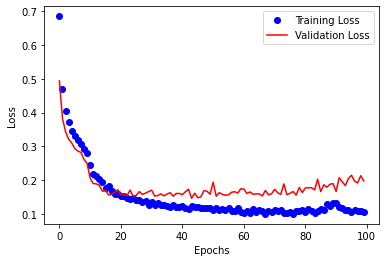

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [144]:
#experimenting with different weights for loss
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1E-1, 0.6], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0446 - decode4_loss: 0.0668 - classifier3_loss: 1.7299 - val_loss: 0.7284 - val_decode4_loss: 0.0586 - val_classifier3_loss: 1.2042
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.7035 - decode4_loss: 0.0595 - classifier3_loss: 1.1626 - val_loss: 0.5239 - val_decode4_loss: 0.0565 - val_classifier3_loss: 0.8637
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5510 - decode4_loss: 0.0581 - classifier3_loss: 0.9086 - val_loss: 0.4077 - val_decode4_loss: 0.0553 - val_classifier3_loss: 0.6702
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4633 - decode4_loss: 0.0569 - classifier3_loss: 0.7627 - val_loss: 0.3731 - val_decode4_loss: 0.0543 - val_classifier3_loss: 0.6128
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4050 - decode4_loss: 0.0560 - classifier3_loss: 0.6657 - val_loss: 0.3054 - val_decode4

313/313 [==============================] - 1s 4ms/step - loss: 0.1914 - decode4_loss: 0.0538 - classifier3_loss: 0.3100 - val_loss: 0.2613 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4267
Epoch 41/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1949 - decode4_loss: 0.0539 - classifier3_loss: 0.3158 - val_loss: 0.2594 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.4236
Epoch 42/100
313/313 [==============================] - 1s 3ms/step - loss: 0.1834 - decode4_loss: 0.0538 - classifier3_loss: 0.2967 - val_loss: 0.2936 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4806
Epoch 43/100
313/313 [==============================] - 1s 3ms/step - loss: 0.1883 - decode4_loss: 0.0538 - classifier3_loss: 0.3049 - val_loss: 0.2591 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4231
Epoch 44/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1891 - decode4_loss: 0.0539 - classifier3_loss: 0.3061 - val_loss: 0.2943 - val_decode4_loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.1744 - decode4_loss: 0.0538 - classifier3_loss: 0.2817 - val_loss: 0.2683 - val_decode4_loss: 0.0526 - val_classifier3_loss: 0.4385
Epoch 80/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1743 - decode4_loss: 0.0539 - classifier3_loss: 0.2815 - val_loss: 0.2532 - val_decode4_loss: 0.0526 - val_classifier3_loss: 0.4132
Epoch 81/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1768 - decode4_loss: 0.0539 - classifier3_loss: 0.2857 - val_loss: 0.2545 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.4154
Epoch 82/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1817 - decode4_loss: 0.0539 - classifier3_loss: 0.2939 - val_loss: 0.2778 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.4543
Epoch 83/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1738 - decode4_loss: 0.0540 - classifier3_loss: 0.2807 - val_loss: 0.2622 - val_decode4_loss: 0

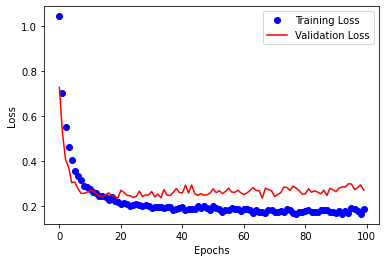

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

I added dropout to the network. It seems to have helped. I experimented with different weights for loss but ended up sticking with the originial weights of: 1 and 0.5, respectively. 

### 4.3. Visualize the reconstructed test images

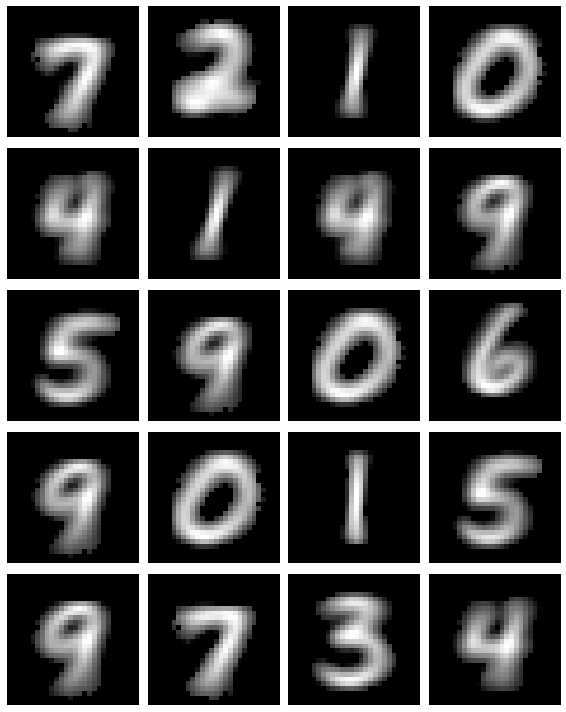

In [159]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [160]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "functional_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
regularization1 (Dropout)    (None, 128)               0         
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_______________________________________________

Shape of encoded_test: (10000, 2)


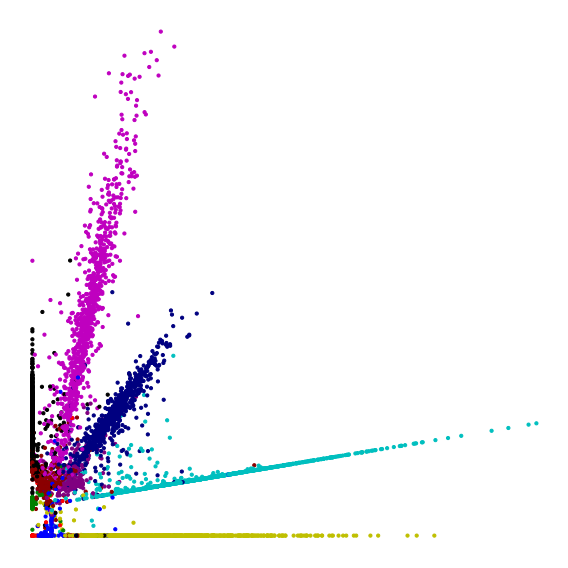

In [161]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.


In [162]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [163]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [164]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 0s 1ms/step - loss: 1.8533 - acc: 0.2791 - val_loss: 1.6055 - val_acc: 0.4616
Epoch 2/30
313/313 [==============================] - 0s 933us/step - loss: 1.3814 - acc: 0.4938 - val_loss: 1.2385 - val_acc: 0.6509
Epoch 3/30
313/313 [==============================] - 0s 932us/step - loss: 1.0230 - acc: 0.7895 - val_loss: 0.9344 - val_acc: 0.8393
Epoch 4/30
313/313 [==============================] - 0s 919us/step - loss: 0.7131 - acc: 0.9403 - val_loss: 0.6831 - val_acc: 0.9368
Epoch 5/30
313/313 [==============================] - 0s 957us/step - loss: 0.4581 - acc: 0.9806 - val_loss: 0.5099 - val_acc: 0.9348
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2892 - acc: 0.9809 - val_loss: 0.4257 - val_acc: 0.9335
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1974 - acc: 0.9806 - val_loss: 0.3956 - val_acc: 0.9335
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - 

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [165]:
# evaluate your model on the never-seen-before test data
# write your code here:
loss = sae.evaluate(x_test, [x_test, y_test_vec])
print('loss = ' + str(loss))

313/313 [==============================] - 0s 928us/step - loss: 0.2420 - decode4_loss: 0.0517 - classifier3_loss: 0.3807
loss = [0.2420233190059662, 0.05165098235011101, 0.38074439764022827]
